# 4. Svhn Data preprocessing

In [19]:
%matplotlib inline
from __future__ import print_function
from matplotlib import pyplot as plt
import collections
import os, struct
import numpy as np
import scipy as sp
import scipy.io
import random
import math
from random import randint
import string
import tensorflow as tf
import gzip
import zlib
import tarfile
import pandas as pd
from six.moves import range
from six.moves.urllib.request import urlretrieve
from array import array as pyarray 
from six.moves import cPickle as pickle
from scipy.misc import imresize
from IPython.display import Image, display
from os import listdir
import skimage
from skimage import data
from skimage import exposure
from skimage import img_as_ubyte
from skimage.transform import resize
from skimage.transform import rescale
from skimage.transform import rotate
from skimage import novice

In [20]:
svhn_dest_folder = "data/svhn/"

def loadPickle(file):
    with open(file, 'rb') as pickle_file:
        return pickle.load(pickle_file)

# Preprocessing

We follow the reference paper preprocessing method: From the digits bounding boxes we will compute the smallest rectangle bounding the entire street number. We will add 30% to it (15% in each direction) and crop around it. Then we will resize to 74x74, and finally we'll do random crops with dimensions 64x64. This is different from the paper which ends up feeding 54x54 images to the model, 64x64 dimensions were just easier to work with as they are powers of 2. Finally we'll subtract the mean from pixels values


The methods below are used to generate data ready to feed to a Tensorflow model. The data will be serialized in Tensorflow's `tf.train.Example` format and saved as `tf.records` files that can be fed to a model with `QueueRunners`

In [21]:
def img_to_array(path, bounding_box, dims=(64,64), grey=False, random_rotate=0, random_crop=10):
    '''
    Converts an image file to a numpy array.
    random_rotate: random angle within range in degrees
    bounding_box: crop to bounding box as described in Google's paper
    random_crop: random location cropping as described in Google's paper
    
    '''
    img = data.imread(path, as_grey=grey)
    
    if random_rotate > 0:
        img = rotate(img,randint(-random_rotate,random_rotate+1),mode='wrap')
        
    # crop bounding box + 30% and resize
    [left,top,right,bottom] = bounding_box
    width = right - left
    height = bottom - top
    left = max(0,int(left - width * 0.15))
    right = min(img.shape[1],int(right + width * 0.15))
    top = max(0,int(top - height * 0.15))
    bottom = min(img.shape[0],int(bottom + height * 0.15))
    img = img[top:bottom,left:right]
    img = resize(img,(dims[0]+random_crop, dims[1]+random_crop))

    # Crop at random location to produce a 54x54 image
    if random_crop > 0:
        random_crop = randint(0,random_crop)
        top = randint(0,random_crop+1)
        bottom = img.shape[0]-(random_crop-top)
        left = randint(0,random_crop+1)
        right = img.shape[1]-(random_crop-left)
        img = img[top:bottom,left:right]
        img = resize(img,dims)

    # subtract mean
    img -= img.mean()
    return img

def create_image_data(folder,dataframe, dims=(64,64), grey=False, random_rotate=False, random_crop=False):
    ''' Create numpy arrays containing the data
    image_data: actual pixels
    digits: digits filled with 0s. 123 will be [1,2,3,0,0,0]
    lengths: 0 indexed lengths labels (0 means length is 1)
    '''
    image_data = np.zeros((dataframe.shape[0],dims[0],dims[1],1 if grey else 3), dtype=float)
    values = np.zeros(dataframe.shape[0],dtype=int)
    digits = np.zeros((values.shape[0],6),dtype=int)
    lengths = np.zeros((dataframe.shape[0],),dtype=int)
    
    for i, row in dataframe.iterrows():
        values[i] = row['value'] 
        lengths[i] = row['length'] - 1 # lengths are classes -> must be 0-indexed
        max_len = min(len(row['digits']),6)
        digits[i,0:lengths[i]+1] = row['digits'][:max_len]        
        imdata = img_to_array(os.path.join(folder,row['filename']),row['box'],
                              (dims[0],dims[1]),grey,random_rotate,random_crop)
        if grey:
            imdata = imdata.reshape((imdata.shape[0],imdata.shape[1],1))
        image_data[i] = imdata

    return image_data,digits,values,lengths

def sample_data(data, digits, values, lengths):
    """
    Display a sample of the data
    """
#     data, digits, values, lengths = loadPickle(tuple_pickle_file)
    indices = np.random.randint(data.shape[0]-1,size=10)
    print ()
    fig = plt.figure(figsize=(12, 6), dpi=80)
    for index,indice in enumerate(indices):
        plt.subplot(4,5,index+1)
        plt.title(str(values[indice]) + " - length:" + str(lengths[indice]+1))
        if data[indice].shape[2] == 1:
            plt.imshow(data[indice,:,:,0], interpolation='nearest',cmap="gray")
        else:
            plt.imshow(img_as_ubyte(data[indice]+0.35), interpolation='nearest',cmap=cmap)
        plt.tight_layout()
    plt.show()

In [22]:
def save_as_tfrecords(data,digits,values,lengths,filename,start_index=0,items_per_file=1000):
    assert len(data) == len(digits)
    assert len(data) ==  len(lengths)
    assert len(data) == len(values)
    num_files = int(math.ceil(len(data) / float(items_per_file)))
    for k in range(num_files):
        current_filename = str("%s.%d.tfrecords" % (filename,k+start_index))
        writer = tf.python_io.TFRecordWriter(current_filename)
        shape = data.shape
        range_in = k * items_per_file
        range_out = min(len(data), (k+1) * items_per_file)
        for i in range(range_in, range_out):
            # construct the Example proto boject
            example = tf.train.Example(
                # Example contains a Features proto object
                features=tf.train.Features(
                  # Features contains a map of string to Feature proto objects
                  feature={
                    # A Feature contains one of either a int64_list,
                    # float_list, or bytes_list
                    'data': tf.train.Feature(float_list=tf.train.FloatList(value=data[i].reshape(shape[1] * shape[2] * shape[3]))),
                    'labels_length': tf.train.Feature(int64_list=tf.train.Int64List(value=[lengths[i]])),
                    'labels_digits': tf.train.Feature(int64_list=tf.train.Int64List(value=digits[i])),
                    'labels_value': tf.train.Feature(int64_list=tf.train.Int64List(value=[values[i]]))

            }))
            # use the proto object to serialize the example to a string
            serialized = example.SerializeToString()
            # write the serialized object to disk
            writer.write(serialized)
                                                    
    print ("%s.[%d-%d].tfrecords files saved." % (filename, start_index, (start_index + num_files -1)))
    return num_files + start_index

In [23]:
def check_tf_records(filename,w,h,channels):
    
    image = 0
    count = 0
    fig = plt.figure(figsize=(12, 4), dpi=80)
    for serialized_example in tf.python_io.tf_record_iterator(filename):
        if count > 11:
            break
        example = tf.train.Example()
        example.ParseFromString(serialized_example)

        # traverse the Example format to get data
        length = example.features.feature['labels_length'].int64_list.value
        digits = example.features.feature['labels_digits'].int64_list.value
        image = example.features.feature['data'].float_list.value
        image = np.array(image)
        plt.subplot(2,6,count+1)
        plt.title(str(np.array(digits)) + " - l:" + str(length))
        if channels == 1:
            image = image.reshape((w,h))+0.35
            image[image > 1.0] = 1.0
            plt.imshow(image, interpolation='nearest',cmap="gray")
        else:
            image = image.reshape((w,h,channels))+0.35
            image[image > 1.0] = 1.0
            plt.imshow(img_as_ubyte(image), interpolation='nearest')
        plt.tight_layout()
        count +=1
    plt.show()

## Validation dataset
We will take a validation dataset from the training set. 10% of the data will be set aside in the validation set so the test set can remain untouched.

In [15]:
train_df = loadPickle(os.path.join(svhn_dest_folder,"train","digitStruct_nozeros.dataframe"))
test_df = loadPickle(os.path.join(svhn_dest_folder,"test","digitStruct_nozeros.dataframe"))
extra_df = loadPickle(os.path.join(svhn_dest_folder,"extra","digitStruct_nozeros.dataframe"))

In [11]:
train_df = train_df.reindex(np.random.permutation(train_df.index)).reset_index(drop=True)
split = int(train_df.shape[0] * 0.9)
valid_df = train_df[split:].reset_index(drop=True)
train_df = train_df[:split]

In [13]:
print ("Training set size: %d" % train_df.shape[0])
print ("Validation set size: %d" % valid_df.shape[0])
print ("Test set size: %d" % test_df.shape[0])

display(train_df.head())
display(valid_df.head())
display(test_df.head())

Training set size: 30010
Validation set size: 3335
Test set size: 13054


,filename,value,digits,length,width,height,box
0,1102.png,59.0,"[5, 9]",2.0,58.0,24.0,"[19, 4, 40, 20]"
1,18122.png,18.0,"[1, 8]",2.0,80.0,38.0,"[29, 3, 54, 33]"
2,22383.png,184.0,"[1, 8, 4]",3.0,280.0,78.0,"[110, 19, 138, 39]"
3,16690.png,39.0,"[3, 9]",2.0,56.0,28.0,"[16, 2, 38, 25]"
4,17385.png,8.0,[8],1.0,85.0,45.0,"[31, 5, 55, 39]"


,filename,value,digits,length,width,height,box
0,4047.png,568.0,"[5, 6, 8]",3.0,311.0,92.0,"[67, 16, 160, 79]"
1,18298.png,17.0,"[1, 7]",2.0,107.0,42.0,"[34, 1, 77, 40]"
2,32597.png,30.0,"[3, 0]",2.0,150.0,70.0,"[56, 17, 89, 51]"
3,21640.png,601.0,"[6, 0, 1]",3.0,182.0,76.0,"[68, 8, 125, 60]"
4,634.png,588.0,"[5, 8, 8]",3.0,169.0,65.0,"[63, 19, 119, 49]"


,filename,value,digits,length,width,height,box
0,1.png,5.0,[5],1.0,99.0,47.0,"[43, 7, 62, 37]"
1,2.png,210.0,"[2, 1, 0]",3.0,182.0,48.0,"[99, 5, 133, 31]"
2,3.png,6.0,[6],1.0,101.0,31.0,"[61, 6, 72, 22]"
3,4.png,1.0,[1],1.0,75.0,31.0,"[32, 6, 46, 23]"
4,5.png,9.0,[9],1.0,215.0,81.0,"[97, 28, 116, 56]"


## Grey scale images
We'll use a grey scaled image dataset for model development. It contains the same difficulties as the colored one but with only one channel, it takes 3 times less resources.

In [38]:
train_dir = os.path.join("data","tfrecords","greys","train")
valid_dir = os.path.join("data","tfrecords","greys","valid")
test_dir = os.path.join("data","tfrecords","greys","test")
for d in [train_dir,valid_dir,test_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

In [15]:
img_data, img_digits,img_values, img_lengths = create_image_data(os.path.join(svhn_dest_folder,'train'),train_df,(64,64), grey=True, random_rotate=5, random_crop=10)
save_as_tfrecords(img_data,img_digits,img_values,img_lengths,os.path.join(train_dir,"svhn-64x64-greyscale-train"))

img_data, img_digits,img_values, img_lengths = create_image_data(os.path.join(svhn_dest_folder,'train'),valid_df,(64,64), grey=True, random_rotate=0, random_crop=0)
save_as_tfrecords(img_data,img_digits,img_values,img_lengths,os.path.join(valid_dir,"svhn-64x64-greyscale-valid"))

img_data, img_digits,img_values, img_lengths = create_image_data(os.path.join(svhn_dest_folder,'test'),test_df,(64,64), grey=True, random_rotate=0, random_crop=0)
save_as_tfrecords(img_data,img_digits,img_values,img_lengths,os.path.join(test_dir,"svhn-64x64-greyscale-test"))

data/tfrecords/greys/train/svhn-64x64-greyscale-train.[0-30].tfrecords files saved.
data/tfrecords/greys/valid/svhn-64x64-greyscale-valid.[0-3].tfrecords files saved.
data/tfrecords/greys/test/svhn-64x64-greyscale-test.[0-13].tfrecords files saved.


14


Training set check


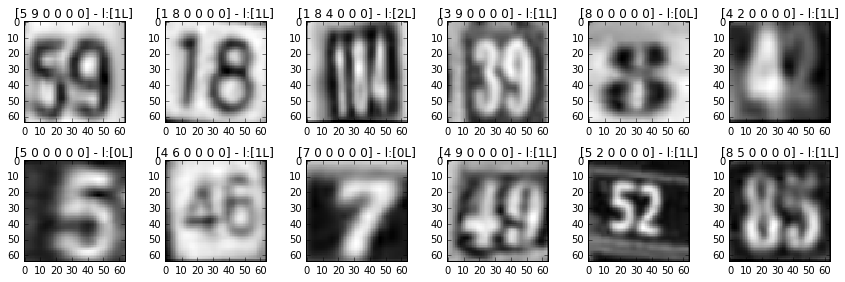

Validation set check


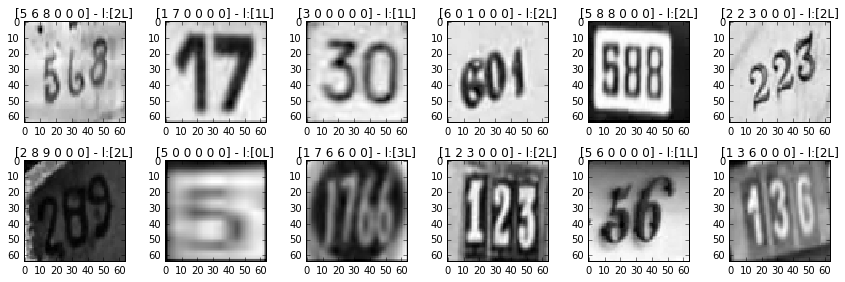

Test set check


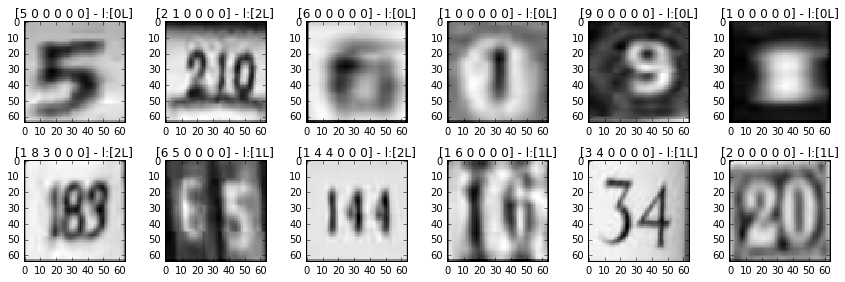

In [39]:
print("\nTraining set check")
check_tf_records(os.path.join(train_dir,'svhn-64x64-greyscale-train.0.tfrecords'),64,64,1)
print("Validation set check")
check_tf_records(os.path.join(valid_dir,'svhn-64x64-greyscale-valid.0.tfrecords'),64,64,1)
print("Test set check")
check_tf_records(os.path.join(test_dir,'svhn-64x64-greyscale-test.0.tfrecords'),64,64,1)

## RGB images
We'll apply the same transformations to create the RGB final training set but we will augment it.
Random crops helps augmenting the data as sames images will be cropped differently. We'll also randomly alterate the colors à la Krizhevsky

A notable difference with Krizhevsky's setup is that those alterations are performed statically in the dataset, whereas he suggests to do them online on every batch at training time on the CPU. It is certainly a better option as it makes the dataset virtually infinite but requires resources we don't have for this project.

### Color perturbations
The code below, inspired from https://desaideshna.wordpress.com/2016/06/30/data-augmentation-with-scikit-image/ perturbates the color of images in AlexNet fashion. Krizhevsky describes it as follows
> altering the intensities of the RGB channels in training images. Specifically, we perform PCA
> on the set of RGB pixel values throughout the ImageNet training set.
> To each training image, we add multiples of the found principal
> components, with magnitudes proportional to the corresponding
> eigenvalues times a random variable drawn from a Gaussian
> with mean zero and standard deviation 0.1.

Applying these perturbations to our images allows to augment our dataset by adding the same images with slight variations of colors and lighting. Somehow it's equivalent to taking pictures of the same street numbers under different lighting and weather conditions

In [24]:
from numpy import linalg as LA
def perturbate(img_array_source, mu=0, sigma=0.1):
    img_array = np.copy(img_array_source)
    perturbate_colors(img_array, mu, sigma)
    return img_array

def perturbate_colors(img_array, mu, sigma):
    size = img_array.shape[0]
    w = img_array.shape[1]
    h = img_array.shape[2]

    channels = img_array.shape[3]
    R = np.zeros((size,channels,channels))
    # Reshape our images in order to obtain 3 vectors, one for each channel (R,G,B)
    img_array =  img_array.reshape(-1,w * h, channels)
    for i in range(size):
        
        # compute covariance on the mean suppressed array
        R = np.cov(img_array[i] - img_array[i].mean(axis=0), rowvar=False)
        # computing eigenvectors and eignevalues
        evals, evecs = LA.eigh(R)
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        # sort eigenvectors according to same index
        evals = evals[idx]
        # select the best 3 eigenvectors (3 is desired dimension
        # of rescaled data array)
        evecs = evecs[:, :3]
        # make a matrix with the three eigenvectors as its columns.
        evecs_mat = np.column_stack((evecs))
        # computing PCA
        m = np.dot(evecs.T, img_array[i].T).T

    img_array = img_array.reshape(-1,w, h, channels)
    for i in range(size):
        augment_color(img_array[i],evecs_mat,evals,w,h,channels,mu, sigma)
        
def augment_color(img,evecs_mat,evals,w,h,channels, mu, sigma):
    feature_vec=np.matrix(evecs_mat)
    # 3 x 1 scaled eigenvalue matrix
    se = np.zeros((3,1))
    se[0][0] = np.random.normal(mu, sigma)*evals[0]
    se[1][0] = np.random.normal(mu, sigma)*evals[1]
    se[2][0] = np.random.normal(mu, sigma)*evals[2]
    se = np.matrix(se)
    val = np.array(feature_vec*se)
    val = np.ones((w,h,channels)) * val.reshape((channels,))
    img += val
    img[img > 1.0] = 1.0

def sample_augmented(base, augmented, cmap=None):
    """
    Prints digits as image along with their labels
    """
    indices = np.random.randint(base.shape[0]-1,size=6)
    fig = plt.figure(figsize=(12, 8), dpi=80)
    for index,indice in enumerate(indices):
        plt.subplot(4,6,2*index+1)
        plt.title("Original")
        
        plt.imshow(img_as_ubyte(base[indice]+0.35), interpolation='nearest',cmap=cmap)

        plt.subplot(4,6,2*index+2)
        plt.title("Perturbated")
        plt.imshow(img_as_ubyte(augmented[indice]+0.35), interpolation='nearest',cmap=cmap)
        plt.tight_layout()
    plt.show()

Below are examples of color alterations. The differences are subtle

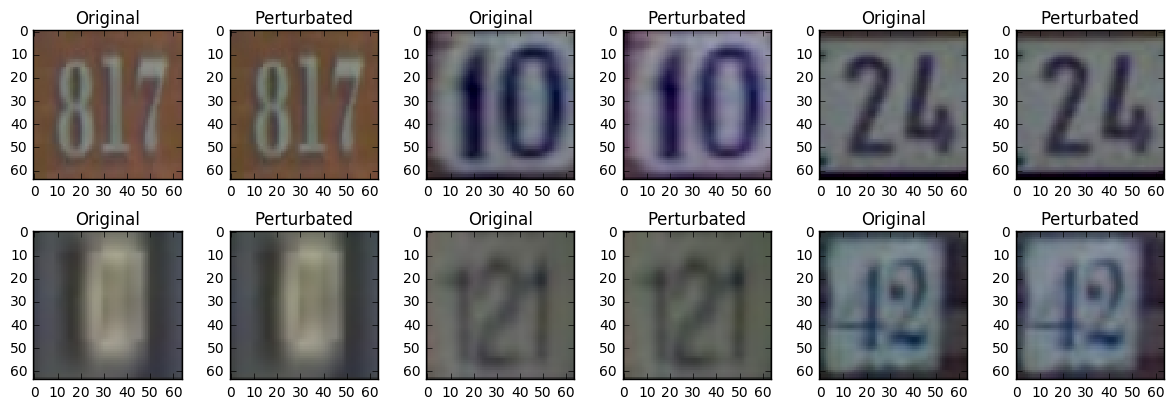

In [25]:
img_data, _,_,_ = create_image_data(os.path.join(svhn_dest_folder,'train'),train_df[:50],(64,64))
img_data_p = perturbate(img_data, mu=0, sigma=2)
sample_augmented(img_data,img_data_p)
del img_data,img_data_p 

### Augmentation and Generation
Let's augment our dataset meta data by concatenating 10 times and shufling it. Then we split the new dataframe in 10 smaller dataframes (for memory concerns)

In [31]:
multiplier = 20
train_df_aug = pd.concat([train_df for i in range(multiplier)]).reset_index(drop=True)
train_df_aug = train_df_aug.reindex(np.random.permutation(train_df_aug.index)).reset_index(drop=True)
train_dfs = np.array_split(train_df_aug, multiplier)
for i in range(multiplier):
    train_dfs[i].reset_index(drop=True, inplace=True)

Let's create the final dataset files. Note how we iterate through the 20 training dataframes. **This operation takes several (6-10) hours.** 

In [7]:
train_dir = os.path.join("data","tfrecords","rgb","train")
valid_dir = os.path.join("data","tfrecords","rgb","valid")
test_dir = os.path.join("data","tfrecords","rgb","test")
test_cropped_dir = os.path.join("data","tfrecords","rgb","test-cropped")
for d in [train_dir,valid_dir,test_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

In [34]:
start_index = 0
for df in train_dfs:
    img_data, img_digits,img_values, img_lengths = create_image_data(os.path.join(svhn_dest_folder,'train'),df,(64,64), random_rotate=5, random_crop=10)
    img_data = perturbate(img_data,mu=0,sigma=1)
    start_index = save_as_tfrecords(img_data,img_digits,img_values,img_lengths,os.path.join(train_dir,"svhn-64x64-rgb-train"), start_index=start_index, items_per_file=1000)

img_data, img_digits,img_values, img_lengths = create_image_data(os.path.join(svhn_dest_folder,'train'),valid_df,(64,64), random_rotate=0, random_crop=0)
save_as_tfrecords(img_data,img_digits,img_values,img_lengths,os.path.join(valid_dir,"svhn-64x64-rgb-valid"))

img_data, img_digits,img_values, img_lengths = create_image_data(os.path.join(svhn_dest_folder,'test'),test_df,(64,64), random_rotate=0, random_crop=0)
save_as_tfrecords(img_data,img_digits,img_values,img_lengths,os.path.join(test_dir,"svhn-64x64-rgb-test"))

data/tfrecords/rgb/train/svhn-64x64-rgb-train.[0-30].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[31-61].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[62-92].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[93-123].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[124-154].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[155-185].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[186-216].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[217-247].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[248-278].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[279-309].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[310-340].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[341-371].tfrecords files saved.
data/tfrecords/rgb/train/svhn-64x64-rgb-train.[372-402].tfre

14


Training set check


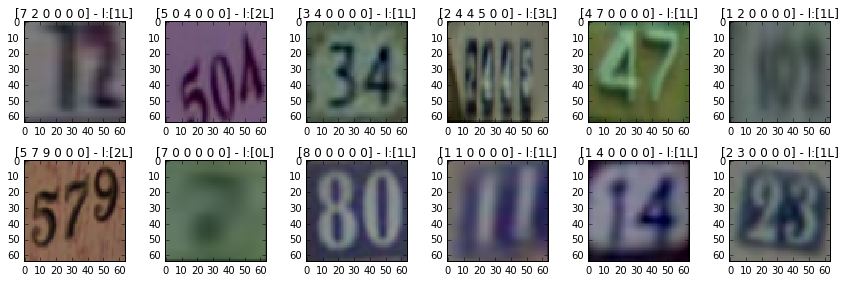

Validation set check


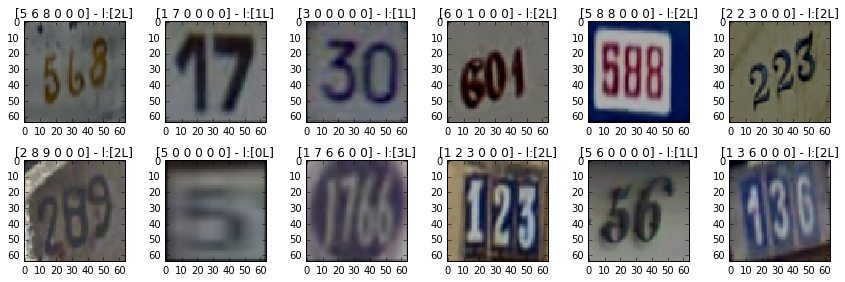

Test set check


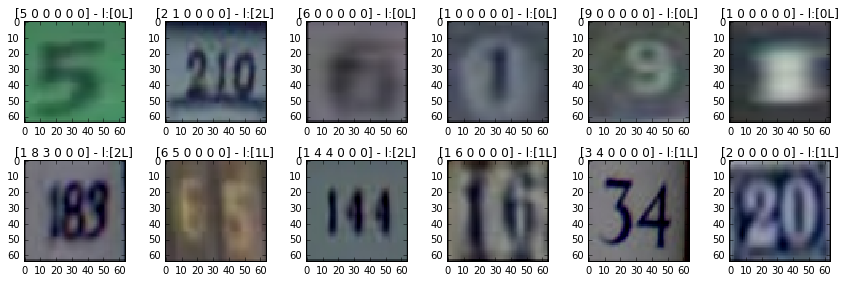

In [41]:
print("\nTraining set check")
check_tf_records(os.path.join(train_dir,'svhn-64x64-rgb-train.0.tfrecords'),64,64,3)
print("Validation set check")
check_tf_records(os.path.join(valid_dir,'svhn-64x64-rgb-valid.0.tfrecords'),64,64,3)
print("Test set check")
check_tf_records(os.path.join(test_dir,'svhn-64x64-rgb-test.0.tfrecords'),64,64,3)

It is not clear in the paper if the same preprocessing has been applied to the validation and the test sets. Random crops in the test set makes it unique to an implementation and results are less comparable. On the other hand, skipping the last step requires to resize to 64x64 instead of 74x74 which creates a scale variation between training and test data. The test set above has no random crops, but since it's resized to 64x64 street numbers are smalles.

Let's create a second version of the test set where images have the same preprocessing as in the training set.

data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.[0-13].tfrecords files saved.
Cropped Test set check


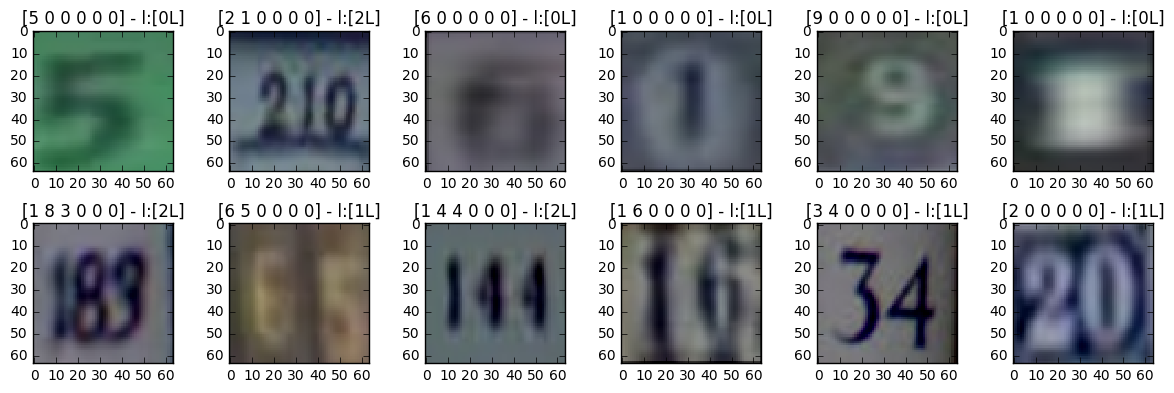

In [18]:
img_data, img_digits,img_values, img_lengths = create_image_data(os.path.join(svhn_dest_folder,'test'),test_df,(64,64), random_rotate=0, random_crop=10)
save_as_tfrecords(img_data,img_digits,img_values,img_lengths,os.path.join(test_cropped_dir,"svhn-64x64-rgb-test"))
print("Cropped Test set check")
check_tf_records(os.path.join(test_cropped_dir,'svhn-64x64-rgb-test.0.tfrecords'),64,64,3)

### Upload on Google Cloud Storage

- Create a project on Google Cloud and a **regional** bucket on Google Cloud Storage.
- Download and install `gcloud` from https://cloud.google.com/sdk/downloads
- run `gcloud auth login` in your shell to authenticate `gcloud`
- set your current Google Cloud project with `gcloud config set project [PROJECT_ID]`
- verify your configuration with `gcloud config list`

In [27]:
project_name = 'svhn-udacity'
bucket_name = 'svhn-data'
gcs_data_folder ='data'
gcs_data_path = 'gs://' + bucket_name + '/' + gcs_data_folder + '/' + 'rgb'
local_data_path = os.path.join("data","tfrecords","rgb")

Then we upload `tfrecords` files in a Google Cloud Storage bucket to train the model in the cloud.
First run `gcloud auth application-default login` in your shell to authenticate 

In [50]:
!gsutil -m  cp -r $local_data_path/train $gcs_data_path/train
!gsutil -m  cp -r $local_data_path/valid $gcs_data_path/valid
!gsutil -m  cp -r $local_data_path/test $gcs_data_path/test

Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.0.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.117.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/.DS_Store [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.10.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.100.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.112.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.111.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.1.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/train/svhn-64x64-rgb-train.101.tfrecords [Content-Ty

In [28]:
!gsutil -m  cp -r $local_data_path/test-cropped $gcs_data_path/test-cropped

Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.1.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.10.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.0.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.11.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.12.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.6.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.5.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/tfrecords/rgb/test-cropped/svhn-64x64-rgb-test.7.tfrecords [Content-Type=application/octet-stream]...
Copying file://data/t